In [1]:
#!pip3 install mplsoccer

In [1]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping, CSVLogger

pd.options.mode.chained_assignment = None

# Data prep 

## Look at match data 

In [2]:
rootdir = 'open-data/data/matches'
# we will use this list to store our clean data and convert it to a dataframe
match_data_clean = []

# loop through each file in the matches directory
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        with open(os.path.join(subdir, file)) as json_file:
            # convert JSON to a list of dicts 
            matches = json.load(json_file)
            for match in matches:
                # extract the match info we may want and append to clean data list
                match_data_clean.append(
                    {
                        'match_id': match['match_id'],
                        'match_date': match['match_date'],
                        'competition': match['competition']['competition_name'],
                        'season': match['season']['season_name'],
                        'home_team': match['home_team']['home_team_name'],
                        'away_team': match['away_team']['away_team_name'],
                        'home_score': match['home_score'],
                        'away_score': match['away_score'],
                    }
                )
# convert to dataframe
match_df = pd.DataFrame(match_data_clean)

In [12]:
match_df.head()

,match_id,match_date,competition,season,home_team,away_team,home_score,away_score
0,69225,2008-12-13,La Liga,2008/2009,Barcelona,Real Madrid,2,0
1,69212,2008-10-04,La Liga,2008/2009,Barcelona,Atlético Madrid,6,1
2,69235,2008-11-01,La Liga,2008/2009,Málaga,Barcelona,1,4
3,69232,2008-10-25,La Liga,2008/2009,Barcelona,Almería,5,0
4,69216,2009-03-07,La Liga,2008/2009,Barcelona,Athletic Bilbao,2,0


## Get event data 

In [6]:
event_data_dir = 'open-data/data/events'
pass_data = []
test = []

# iterate through each file in the events data directory and pull each event if it is a passing event
for filename in tqdm(os.listdir(event_data_dir)):
    if filename.endswith(".json"): 
        with open(os.path.join(event_data_dir, filename)) as json_file:
            match_id = int(filename[:-5])
            data = json.load(json_file)
            for event in data:
                if event.get('type', {}).get('name', None) == 'Pass':
                    pass_data.append(
                        {
                            'match_id': match_id,
                            'event_id': event['id'],
                            'passing_team': event.get('possession_team', {}).get('name', None),
                            'recipient_name': event.get('pass', {}).get('recipient', {}).get('name', None),
                            'passing_player': event.get('player', {}).get('name', None),
                            'passing_player_x_location': event['location'][0],
                            'passing_player_y_location': event['location'][1],
                            'pass_end_location_x': event.get('pass', {})['end_location'][0],
                            'pass_end_location_y': event.get('pass', {})['end_location'][1],
                            'pass_height_category': event.get('pass', {}).get('height', {}).get('name', None),
                            'body_part': event.get('pass', {}).get('body_part', {}).get('name', None),
                            'outcome': event.get('pass', {}).get('outcome', {}).get('name', None)
                        }
                    )
# Note that "None" outcome means complete
pass_df = pd.DataFrame(pass_data)
pass_df.head()

  0%|          | 0/890 [00:00<?, ?it/s]

,match_id,event_id,passing_team,recipient_name,passing_player,passing_player_x_location,passing_player_y_location,pass_end_location_x,pass_end_location_y,pass_height_category,body_part,outcome
0,2275050,c0927b64-b182-4e44-83f0-b77222d600f8,Birmingham City WFC,Lucy Staniforth,Rachel Williams,61.0,40.1,53.9,39.6,Ground Pass,Right Foot,None
1,2275050,71905fc2-e4fb-4429-8f44-11c3942ade7d,Birmingham City WFC,Claudia Walker,Lucy Staniforth,52.8,42.7,118.4,72.9,High Pass,Right Foot,None
2,2275050,7c8f43bb-78d6-421b-a485-c8ddb83e7b1d,Reading WFC,Sophie Howard,Rachael Laws,6.0,44.0,13.4,54.2,Ground Pass,Left Foot,None
3,2275050,575a6ca7-9736-4487-bd1f-12ee10011319,Reading WFC,Amalie Vevle Eikeland,Sophie Howard,39.6,58.2,62.0,60.2,Ground Pass,Right Foot,None
4,2275050,719c6c68-fa1e-4aab-ab70-601450bc44d6,Reading WFC,Rachel Williams,Rebecca Holloway,35.8,9.9,69.9,13.3,High Pass,Left Foot,Incomplete


## Prepare modelling dataframe 

In [13]:
# just look at the different outcome types
pass_df.groupby('outcome')['event_id'].count()

outcome
Incomplete          159203
Injury Clearance      1177
Out                  18931
Pass Offside          4051
Unknown               4895
Name: event_id, dtype: int64

In [15]:
# Step 1: remove pass events we don't want
modelling_df = pass_df.loc[
    ~pass_df['outcome'].isin(['Injury Clearance', 'Pass Offside', 'Unknown'])
]

# Step 2: create one hot variables
# pass height and body part
one_hot_pass_height_variables = pd.get_dummies(modelling_df['pass_height_category'])
one_hot_body_part_variables = pd.get_dummies(modelling_df['body_part'])

# tidies up naming befor appending row wise
one_hot_pass_height_variables.columns = [
    col.lower().replace(' ', '_') for col in one_hot_pass_height_variables.columns
]
one_hot_body_part_variables.columns = [
    col.lower().replace(' ', '_') for col in one_hot_body_part_variables.columns
]

modelling_df = pd.concat([modelling_df, one_hot_pass_height_variables], axis=1)
modelling_df = pd.concat([modelling_df, one_hot_body_part_variables], axis=1)

# Step 3: create binary pass complete column
modelling_df['completed'] = 0
modelling_df.loc[modelling_df['outcome'].isna(), 'completed'] = 1

# Step 4: finally filter down to the columns we want
modelling_cols = (
    [
        'passing_player_x_location', 
        'passing_player_y_location', 
        'pass_end_location_x',
        'pass_end_location_y'
    ] + 
    list(one_hot_pass_height_variables.columns) +
    list(one_hot_body_part_variables.columns) + 
    ['completed']
)

modelling_df = modelling_df[modelling_cols]
modelling_df.head()

,passing_player_x_location,passing_player_y_location,pass_end_location_x,pass_end_location_y,ground_pass,high_pass,low_pass,drop_kick,head,keeper_arm,left_foot,no_touch,other,right_foot,completed
0,61.0,40.1,53.9,39.6,1,0,0,0,0,0,0,0,0,1,1
1,52.8,42.7,118.4,72.9,0,1,0,0,0,0,0,0,0,1,1
2,6.0,44.0,13.4,54.2,1,0,0,0,0,0,1,0,0,0,1
3,39.6,58.2,62.0,60.2,1,0,0,0,0,0,0,0,0,1,1
4,35.8,9.9,69.9,13.3,0,1,0,0,0,0,1,0,0,0,0


## Split data into train, validation, and testing partitions and oversample minority class

### Train test split

Train: 80%

Val: 5%

Test: 15%

In [17]:
# Here X represents our predictors (location, height, body part) 
# and y represents our target (completed)
X = modelling_df.iloc[:, :-1]
y = modelling_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=123, stratify=y
)


X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.25, random_state=123, stratify=y_test
)


### Oversample and SMOTE minority class 

In [19]:
negative_samples = y_train.value_counts()[0]
positive_samples = y_train.value_counts()[1]
current_negative_samples = pd.concat([X_train, y_train], axis=1)
current_negative_samples = current_negative_samples.loc[current_negative_samples['completed'] == 0].iloc[:, :-1]
additional_negative_samples = []
y_vals = []

while negative_samples < positive_samples:
    sample_for_smote = current_negative_samples.sample().to_dict(orient='records')[0]
    smote_player_x_loc = sample_for_smote['passing_player_x_location'] + random.uniform(-4, 4)
    # do a small bit of smote
    sample_for_smote['passing_player_x_location'] = (
        sample_for_smote['passing_player_x_location'] + random.uniform(-4, 4)
    )
    sample_for_smote['passing_player_y_location'] = (
        sample_for_smote['passing_player_y_location'] + random.uniform(-4, 4)
    )
    sample_for_smote['pass_end_location_x'] = (
        sample_for_smote['pass_end_location_x'] + random.uniform(-4, 4)
    )
    sample_for_smote['pass_end_location_y'] = (
        sample_for_smote['pass_end_location_y'] + random.uniform(-4, 4)
    )
    additional_negative_samples.append(sample_for_smote)
    y_vals.append(0)
    negative_samples += 1
    
X_train = pd.concat([X_train, pd.DataFrame(additional_negative_samples)]).reset_index(drop=True)
y_train = pd.concat([y_train, pd.Series(y_vals)]).reset_index(drop=True)

# Modelling 

## Functions 

In [ ]:
def create_model():
    model = Sequential()
    
    model.add(BatchNormalization())
    model.add(Dense(128))
    model.add(ReLU())
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(8))
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Fit model 

In [20]:
model = create_model()

# some model callbacks to improve results on monitor training
save_best_model = ModelCheckpoint("pass_model.hdf5",monitor="val_loss")
terminate_on_nan = TerminateOnNaN()
csv_logger = CSVLogger('training.log')
dynamic_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=15, verbose=0, mode='auto', cooldown=0, min_lr=0
)
stop_early = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto'
)

# Here is where the model actually trains
model_history = model.fit(
    np.array(X_train).astype('float32'),
    np.array(y_train).astype('float32'),
    batch_size=128,
    epochs=100,
    verbose = 1,
    callbacks=[save_best_model, terminate_on_nan, dynamic_lr, stop_early, csv_logger],
    validation_data=(
        np.array(X_val).astype('float32'), 
        np.array(y_val).astype('float32')
    ),
    shuffle=True
)

Epoch 1/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.5333 - accuracy: 0.7480 - val_loss: 0.4635 - val_accuracy: 0.7888
Epoch 2/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.4948 - accuracy: 0.7695 - val_loss: 0.4632 - val_accuracy: 0.7873
Epoch 3/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.4893 - accuracy: 0.7740 - val_loss: 0.4338 - val_accuracy: 0.8011
Epoch 4/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.4822 - accuracy: 0.7799 - val_loss: 0.4550 - val_accuracy: 0.7909
Epoch 5/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.4802 - accuracy: 0.7808 - val_loss: 0.4196 - val_accuracy: 0.8083
Epoch 6/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.4781 - accuracy: 0.7818 - val_loss: 0.4462 - val_accuracy: 0.7891
Epoch 7/100
2170/2170 [==============================] - 3s 1ms/step - loss: 0.4746 - accuracy: 0.7850 - val_loss: 0.4151 - val_ac

## Test model 

In [21]:
# load the model
model = load_model("pass_model.hdf5")

y_pred = model.predict(np.array(X_test))
y_prob = y_pred
y_pred = y_pred > 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.85      0.64    106880
           1       0.95      0.80      0.87    416568

    accuracy                           0.81    523448
   macro avg       0.74      0.82      0.76    523448
weighted avg       0.86      0.81      0.82    523448



# Plot some passes 

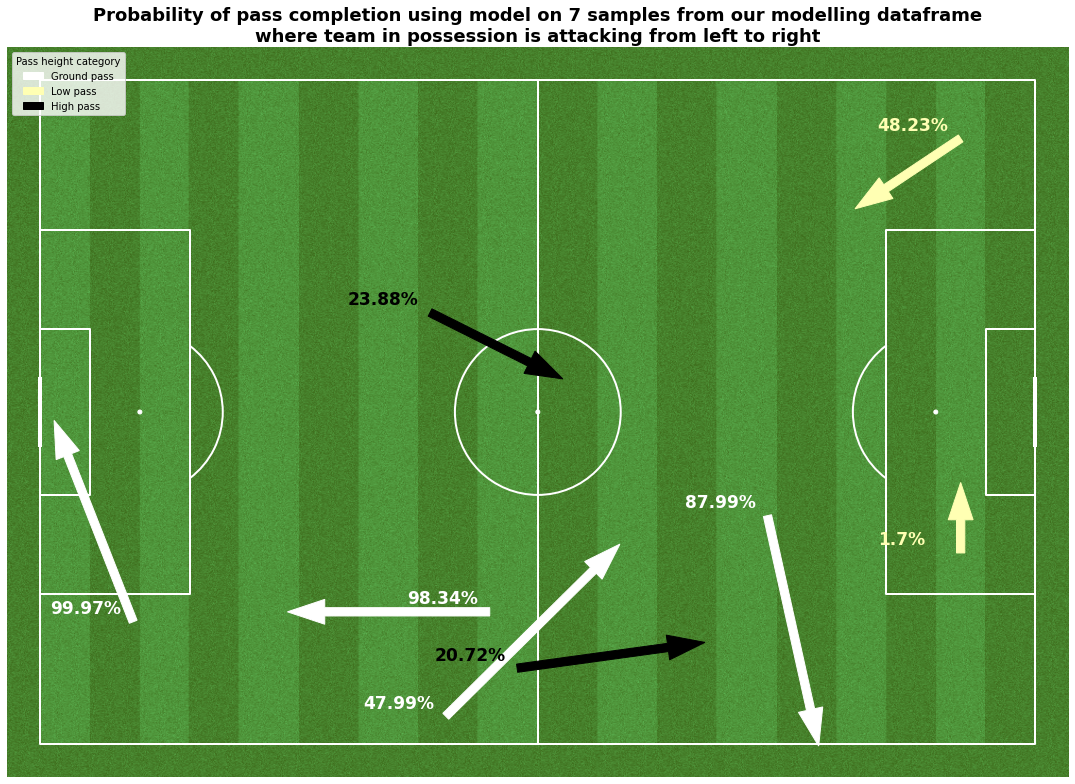

In [16]:
model = load_model("pass_model.hdf5")
samples = modelling_df.sample(8, random_state=64).reset_index(drop=True)
samples['model_prob_success'] = model.predict(np.array(samples.iloc[:, :-1])).tolist()
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw()

fig.set_size_inches(18, 11)
for index, row in samples.iterrows():
    player_x =  row['passing_player_x_location']
    player_y = row['passing_player_y_location']
    ball_end_x = row['pass_end_location_x']
    ball_end_y = row['pass_end_location_y']
    model_prob_success = round(row['model_prob_success'][0]*100, 2)
    colour = 'white' if row['ground_pass'] == 1 else '#ffffb3' if row['low_pass'] == 1 else 'black'
    label = 'Ground pass' if row['ground_pass'] == 1 else 'Low pass' if row['low_pass'] == 1 else 'High pass'
    completed = 1 if row['completed'] ==  1 else 0
    ax.arrow(
        x=player_x, 
        y=player_y, 
        dx=ball_end_x - player_x, 
        dy=ball_end_y - player_y,
        width=1, 
        color=colour,
        label=label,
    )
    ax.annotate(
        f"{model_prob_success}%", 
        xy=(player_x - 10, player_y + 1), 
        color=colour,
        size=17,
        weight='bold'
    )
ax.set_title(
    "Probability of pass completion using model on 7 samples from our modelling dataframe\n"
    "where team in possession is attacking from left to right",
    size=18,
    weight='bold'
)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Pass height category", loc='upper left')
plt.gca().invert_yaxis()
fig.savefig(f"pass_probabilities.png", bbox_inches="tight")
plt.show()

# A detailed look at the Arsenal Invincibles 

## Get predictions for all the teams passes 

In [52]:
# first get all arsenal matches
arsenal_matches = list(match_df.loc[
    (match_df['home_team']=='Arsenal') | (match_df['away_team']=='Arsenal'),
    'match_id'
])

# now filter down to arsenal passes
arsenal_pass_df = pass_df.loc[
    (pass_df['match_id'].isin(arsenal_matches)) & (pass_df['passing_team']=='Arsenal')
]

# create a version of the modelling df for arsenal passes with player names
# remove pass events we don't want
arsenal_modelling_df = arsenal_pass_df.loc[
    ~arsenal_pass_df['outcome'].isin(['Injury Clearance', 'Pass Offside', 'Unknown'])
]
# create binary pass complete column
arsenal_modelling_df['completed'] = 0
arsenal_modelling_df.loc[arsenal_modelling_df['outcome'].isna(), 'completed'] = 1

# create one hot variables
# pass height and body part
one_hot_pass_height_variables = pd.get_dummies(arsenal_modelling_df['pass_height_category'])
one_hot_body_part_variables = pd.get_dummies(arsenal_modelling_df['body_part'])
one_hot_pass_height_variables.columns = [
    col.lower().replace(' ', '_') for col in one_hot_pass_height_variables.columns
]
arsenal_modelling_df = pd.concat([arsenal_modelling_df, one_hot_pass_height_variables], axis=1)

one_hot_body_part_variables.columns = [
    col.lower().replace(' ', '_') for col in one_hot_body_part_variables.columns
]
arsenal_modelling_df = pd.concat([arsenal_modelling_df, one_hot_body_part_variables], axis=1)

arsenal_modelling_df_columns = (
    [
        'passing_player',
        'passing_player_x_location', 
        'passing_player_y_location', 
        'pass_end_location_x',
        'pass_end_location_y'
    ] + 
    list(one_hot_pass_height_variables.columns) +
    list(one_hot_body_part_variables.columns) + 
    ['completed']
)

# finally filter down to the columns we want
arsenal_modelling_df = arsenal_modelling_df[arsenal_modelling_df_columns]
arsenal_modelling_df.head()

# now load the model and predict
model_predictions = [
    prediction[0] for prediction in model.predict(np.array(arsenal_modelling_df.iloc[:, 1:-1])).tolist()
]
arsenal_modelling_df['model_success_probability'] = model_predictions
arsenal_modelling_df.head()

,passing_player,passing_player_x_location,passing_player_y_location,pass_end_location_x,pass_end_location_y,ground_pass,high_pass,low_pass,drop_kick,head,keeper_arm,left_foot,no_touch,other,right_foot,completed,model_success_probability
84265,Sylvain Wiltord,60.0,40.0,58.6,35.4,1,0,0,0,0,0,0,0,0,1,1,0.845504
84266,Thierry Henry,58.7,35.0,45.2,63.9,1,0,0,0,0,0,0,0,0,1,1,0.998318
84267,Laureano Bisan-Etame Mayer,45.2,63.9,31.5,51.9,1,0,0,0,0,0,0,0,0,1,1,0.994847
84268,Martin Keown,28.5,50.5,28.1,22.7,1,0,0,0,0,0,0,0,0,1,1,0.991305
84269,Kolo Habib Touré,36.7,27.1,37.6,60.7,1,0,0,0,0,0,0,0,0,1,1,0.994418


## Who had the lowest and highest expected completion percentage based on our model?

In [74]:
prob_success_per_player = (
    arsenal_modelling_df.groupby('passing_player')
    .agg(
        {
            'model_success_probability':[np.mean, 'count']
        }
    )
)
prob_success_per_player.columns = [
    "mean_success_probability", "number_of_passes_attempted"
]
prob_success_per_player = prob_success_per_player.loc[
    prob_success_per_player['number_of_passes_attempted'] > 100
].reset_index().sort_values(by='mean_success_probability', ascending=False)
prob_success_per_player

,passing_player,mean_success_probability,number_of_passes_attempted
5,Gilberto Aparecido da Silva,0.690199,1339
13,Patrick Vieira,0.683681,1533
14,Ray Parlour,0.681828,684
2,Eduardo César Daude Gaspar,0.674790,834
17,Sylvain Wiltord,0.673927,215
4,Gaël Clichy,0.671568,358
9,Laureano Bisan-Etame Mayer,0.669950,1576
16,"Sulzeer Jeremiah ""Sol"" Campbell",0.667918,915
3,Fredrik Ljungberg,0.663577,758
0,Ashley Cole,0.651180,1457
